# Hidden Markov Model for NER


In [1]:
from app.travel_resolver.libs.nlp.data_processing import from_bio_file_to_examples

BIO_FILE = "data/bio/fr.bio/fr.sentences.bio"

sentences, labels, vocab, unique_labels = from_bio_file_to_examples(
    BIO_FILE, process_sentence=True
)

[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


Splitting the data between **training** and **test** set. We will do an `80/20` split. 

In [58]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, y_train, y_test = train_test_split(sentences, labels, test_size=0.2)

In [59]:
def t2_given_t1(
    t2: str | int,
    t1: str | int,
    train_bag=y_train,
    unique_labels_mapping: dict = unique_labels,
):
    """
    Get the probability of getting t2 given t1 in the given labels

    Args:
      t2: str | int, the second tag
      t1: str | int, the first tag
      train_bag: list, the list of labels

    Returns:
      float, the probability of getting t2 given t1
    """
    t1 = t1 if isinstance(t1, int) else unique_labels_mapping[t1]
    t2 = t2 if isinstance(t2, int) else unique_labels_mapping[t2]
    count_t1 = 0
    count_t2_t1 = 0
    for row in train_bag:
        for index in range(len(row) - 1):
            if row[index] == t1:
                count_t1 += 1
            if row[index] == t1 and row[index + 1] == t2:
                count_t2_t1 += 1
    return count_t2_t1 / count_t1

In the next part, we will be getting the **transition matrix** which represents the _probability_ of transitioning from a state to another $P(S_2 | S_1)$. In our case it would be for example $P(O | \text{ARR-LOC})$.


In [60]:
import numpy as np

tags = list(unique_labels.keys())
n_tags = len(tags)

trans_matrix = np.zeros((n_tags, n_tags))

for t1 in range(n_tags):
    for t2 in range(n_tags):
        trans_matrix[t1][t2] = t2_given_t1(tags[t1], tags[t2])

trans_matrix

array([[0.80661431, 0.92762476, 0.93099861],
       [0.09665682, 0.07237524, 0.        ],
       [0.09672887, 0.        , 0.06900139]])

In [61]:
import pandas as pd

trans_matrix_df = pd.DataFrame(trans_matrix, columns=tags, index=tags)

trans_matrix_df

,O,LOC-ARR,LOC-DEP
O,0.806614,0.927625,0.930999
LOC-ARR,0.096657,0.072375,0.000000
LOC-DEP,0.096729,0.000000,0.069001


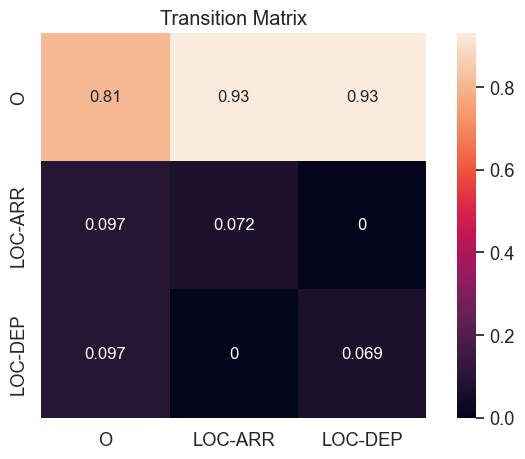

In [62]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

sns.set(font_scale=1.2)

sns.heatmap(trans_matrix_df, annot=True, square=True, annot_kws={"fontsize": 12})

plt.title("Transition Matrix")

plt.show()

In [63]:
def get_emission_prob_dict(sentences: list[str] = train_sentences, labels: list[int] = y_train, tags: dict = unique_labels):
    """
    Given a bunch of sentences and their labels, get the emission probability of each word given each tag
    
    Parameters:
    sentences (list): The list of sentences
    labels (list): The list of labels
    tags (dict): The dictionary of tags
    
    Returns:
    dict: The dictionary of emission probabilities
    """
    tags = list(tags.keys())
    word_label_count = {}
    sample_count = {tag: 0 for tag in tags}
    for i in range(len(sentences)):
        for word, label in zip(sentences[i].split(" "), labels[i]):
            if word not in word_label_count:
                word_label_count[word] = sample_count.copy()
            else:
                word_label_count[word][tags[label]] += 1
    
    for word in word_label_count:
        total_count = sum(word_label_count[word].values())
        for tag in word_label_count[word]:
            if total_count == 0:
                word_label_count[word][tag] = 0
                continue
            word_label_count[word][tag] /= total_count
    return word_label_count

In [64]:
em_prob_dict = get_emission_prob_dict()

em_prob_df = pd.DataFrame(em_prob_dict).T

em_prob_df.head(10)

,O,LOC-ARR,LOC-DEP
je,1.000000,0.000000,0.000000
dois,1.000000,0.000000,0.000000
trouv,1.000000,0.000000,0.000000
un,1.000000,0.000000,0.000000
moyen,1.000000,0.000000,0.000000
de,0.997272,0.001415,0.001314
transport,1.000000,0.000000,0.000000
pour,1.000000,0.000000,0.000000
aller,1.000000,0.000000,0.000000
varennes-vauzel,0.000000,0.571429,0.428571


In [65]:
em_prob = em_prob_df.to_numpy()

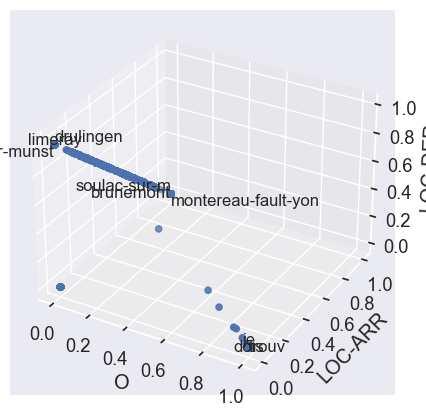

In [66]:
import random

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")

xx = em_prob[:, 0]
yy = em_prob[:, 1]
zz = em_prob[:, 2]

xlabel = list(em_prob_df.columns)[0]
ylabel = list(em_prob_df.columns)[1]
zlabel = list(em_prob_df.columns)[2]

x_count = 0
y_count = 0
z_count = 0
n_notation = 3
for i in range(len(zz)):
    h = random.choice(["center", "right", "left"])
    v = random.choice(["center", "bottom", "top", "baseline"])
    if x_count == n_notation and y_count == n_notation and z_count == n_notation:
        break
    if xx[i] > 0.99 and x_count < n_notation:
        ax.text(xx[i], yy[i], zz[i], em_prob_df.index[i], fontsize=12, ha=h, va=v)
        x_count += 1
    if yy[i] > 0.99 and y_count < n_notation:
        ax.text(xx[i], yy[i], zz[i], em_prob_df.index[i], fontsize=12, ha=h, va=v)
        y_count += 1
    if zz[i] > 0.99 and z_count < n_notation:
        ax.text(xx[i], yy[i], zz[i], em_prob_df.index[i], fontsize=12, ha=h, va=v)
        z_count += 1


ax.scatter(xx, yy, zz)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)

plt.show()


In [67]:
def get_start_prob(labels: list[int] = y_train, tags: dict = unique_labels):
    """
    Get the start probability of each tag
    
    Parameters:
    labels (list): The list of labels
    tags (dict): The dictionary of tags
    
    Returns:
    dict: The dictionary of start probabilities
    """
    tags = list(tags.keys())
    start_prob = {tag: 0 for tag in tags}
    for label in labels:
        start_prob[tags[label[0]]] += 1
    total_count = sum(start_prob.values())
    for tag in start_prob:
        start_prob[tag] /= total_count
    return start_prob

In [68]:
startprob = get_start_prob()

startprob = np.array(list(startprob.values()))

startprob

array([1., 0., 0.])

In [87]:
from hmmlearn.hmm import CategoricalHMM

hmm = CategoricalHMM(n_components=n_tags, n_iter=100, tol=0.01)

hmm.n_features = len(vocab)
hmm.startprob_ = startprob
hmm.transmat_ = trans_matrix
hmm.emissionprob_ = em_prob

In [88]:
from sklearn.preprocessing import LabelEncoder

words = np.array([word for sentence in train_sentences for word in sentence.split(" ")])

word_encoder = LabelEncoder()

x_train = word_encoder.fit_transform(words).reshape(-1, 1)

lengths = [len(sentence.split(" ")) for sentence in train_sentences]

hmm.fit(x_train, lengths)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


CategoricalHMM(n_components=3, n_features=3208, n_iter=100,
               random_state=RandomState(MT19937) at 0x118411B40)

In [89]:
from app.travel_resolver.libs.nlp.data_processing import process_sentence

test_sentence = "Je voudrais voyager de Montpellier à Paris."

test_sentence = process_sentence(test_sentence, stemming=True)

test_sentence = test_sentence.split(" ")

test_sentence = word_encoder.transform(test_sentence).reshape(-1, 1)

predicted_labels = hmm.predict(test_sentence)

for word, label in zip(test_sentence, predicted_labels):
    print(f"{word_encoder.inverse_transform(word)}: {list(unique_labels.keys())[label]}")

['je']: O
['voudr']: LOC-DEP
['voyag']: LOC-ARR
['de']: LOC-ARR
['montpelli']: O
['à']: LOC-DEP
['paris']: LOC-ARR
['.']: O
